# **This file performs below operations** -


ER Modeling - timeframe (2019-2022)
```
1.   Load 'P20_ER.xlsx' - 30-min observations
2.   This already contains all required data columns
3.   If needed perform aggregation at a level (hourly, daily ?)
4.   Probably train on 2019, 2020, 2021 data and test on 2022?
5.   Save the results to pickle files

```





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from os import walk
from time import sleep
from tqdm import tqdm
import pickle
import string
import numpy as np
import pandas as pd
from scipy import stats
from scipy import interpolate
import plotly.express as px
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
main_path = '/content/drive/MyDrive/DS for Ag - Alfalfa/Fall 2023'
data_path = os.path.join(main_path, 'Data')
code_path = os.path.join(main_path, 'Code')

In [4]:
pickle_dir = os.path.join(data_path, 'pickle files')
# save the combined alfalfa data to a pickle file
pickle_dir = os.path.join(data_path, 'pickle files')
if os.path.exists(pickle_dir) == False:
  os.mkdir(pickle_dir)

In [5]:
# Reading pickle file.
pickle_dir = os.path.join(data_path, 'pickle files')
file_name = 'p20_final_df_filtered_viz.pkl'
file_path = os.path.join(pickle_dir, file_name)
with open(file_path, 'rb') as fp:
    p20_final_df_model = pickle.load(fp)

print(p20_final_df_model.head())

                      Rg  Tair  Tsoil     rH   VPD  Ustar       SWC      GPP  \
Date                                                                           
2019-04-01 00:30:00  0.0  2.57   9.73  73.91  0.09   0.05  0.306482  0.55305   
2019-04-01 01:00:00  0.0  2.56   9.39  73.33  0.09   0.03  0.306471  0.55226   
2019-04-01 01:30:00  0.0  1.88   9.12  76.41  0.09   0.02  0.306262  0.49811   
2019-04-01 02:00:00  0.0  1.78   8.83  74.55  0.09   0.03  0.306530  0.49012   
2019-04-01 02:30:00  0.0  1.84   8.57  68.79  0.09   0.03  0.305710  0.49492   

                      NEE        ET       ER  
Date                                          
2019-04-01 00:30:00  0.61  0.000358  1.16305  
2019-04-01 01:00:00  0.29  0.000329  0.84226  
2019-04-01 01:30:00  1.35  0.000964  1.84811  
2019-04-01 02:00:00  0.63  0.000467  1.12012  
2019-04-01 02:30:00  0.76  0.000832  1.25492  


In [6]:
p20_final_df_model

,Rg,Tair,Tsoil,rH,VPD,Ustar,SWC,GPP,NEE,ET,ER
Date,,,,,,,,,,,
2019-04-01 00:30:00,0.00,2.57,9.73,73.91,0.09,0.05,0.306482,0.55305,0.61,0.000358,1.16305
2019-04-01 01:00:00,0.00,2.56,9.39,73.33,0.09,0.03,0.306471,0.55226,0.29,0.000329,0.84226
2019-04-01 01:30:00,0.00,1.88,9.12,76.41,0.09,0.02,0.306262,0.49811,1.35,0.000964,1.84811
2019-04-01 02:00:00,0.00,1.78,8.83,74.55,0.09,0.03,0.306530,0.49012,0.63,0.000467,1.12012
2019-04-01 02:30:00,0.00,1.84,8.57,68.79,0.09,0.03,0.305710,0.49492,0.76,0.000832,1.25492
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 18:00:00,19.41,11.24,6.75,64.57,0.89,0.13,0.283907,0.00000,3.78,-0.002453,3.78000
2022-12-31 19:30:00,0.00,7.50,6.58,75.85,0.00,0.07,0.284217,0.00000,1.59,0.000767,1.59000
2022-12-31 20:30:00,0.00,7.97,6.41,71.28,1.41,0.10,0.284302,0.00000,1.69,0.001927,1.69000


In [7]:
p20_final_df_model.isnull().sum()/len(p20_final_df_model)

Rg       0.0
Tair     0.0
Tsoil    0.0
rH       0.0
VPD      0.0
Ustar    0.0
SWC      0.0
GPP      0.0
NEE      0.0
ET       0.0
ER       0.0
dtype: float64

In [8]:
#p20_final_df_model = p20_final_df_model.dropna()

In [9]:
p20_final_df_mod = p20_final_df_model.copy()

In [10]:
p20_final_df_mod1 = p20_final_df_model.copy()

In [11]:
#Tair * VPD
p20_final_df_mod['Tair * VPD'] = p20_final_df_mod['Tair']* p20_final_df_mod['VPD']

In [12]:
#SWC * Tsoil
p20_final_df_mod['SWC * Tsoil'] = p20_final_df_mod['SWC']* p20_final_df_mod['Tsoil']

In [16]:
p20_final_df_model_GPP = p20_final_df_mod.drop(['NEE','ET'], axis = 1)

In [17]:
p20_final_df_model_NEE = p20_final_df_mod.drop(['GPP','ET'], axis = 1)
p20_final_df_model_ET = p20_final_df_mod.drop(['GPP','NEE'], axis = 1)

In [18]:
p20_final_df_model_GPP

,Rg,Tair,Tsoil,rH,VPD,Ustar,SWC,GPP,ER
Date,,,,,,,,,
2019-04-01 00:30:00,0.00,2.57,9.73,73.91,0.09,0.05,0.306482,0.55305,1.16305
2019-04-01 01:00:00,0.00,2.56,9.39,73.33,0.09,0.03,0.306471,0.55226,0.84226
2019-04-01 01:30:00,0.00,1.88,9.12,76.41,0.09,0.02,0.306262,0.49811,1.84811
2019-04-01 02:00:00,0.00,1.78,8.83,74.55,0.09,0.03,0.306530,0.49012,1.12012
2019-04-01 02:30:00,0.00,1.84,8.57,68.79,0.09,0.03,0.305710,0.49492,1.25492
...,...,...,...,...,...,...,...,...,...
2022-12-31 18:00:00,19.41,11.24,6.75,64.57,0.89,0.13,0.283907,0.00000,3.78000
2022-12-31 19:30:00,0.00,7.50,6.58,75.85,0.00,0.07,0.284217,0.00000,1.59000
2022-12-31 20:30:00,0.00,7.97,6.41,71.28,1.41,0.10,0.284302,0.00000,1.69000


In [19]:
p20_final_df_model_NEE

,Rg,Tair,Tsoil,rH,VPD,Ustar,SWC,NEE,ER
Date,,,,,,,,,
2019-04-01 00:30:00,0.00,2.57,9.73,73.91,0.09,0.05,0.306482,0.61,1.16305
2019-04-01 01:00:00,0.00,2.56,9.39,73.33,0.09,0.03,0.306471,0.29,0.84226
2019-04-01 01:30:00,0.00,1.88,9.12,76.41,0.09,0.02,0.306262,1.35,1.84811
2019-04-01 02:00:00,0.00,1.78,8.83,74.55,0.09,0.03,0.306530,0.63,1.12012
2019-04-01 02:30:00,0.00,1.84,8.57,68.79,0.09,0.03,0.305710,0.76,1.25492
...,...,...,...,...,...,...,...,...,...
2022-12-31 18:00:00,19.41,11.24,6.75,64.57,0.89,0.13,0.283907,3.78,3.78000
2022-12-31 19:30:00,0.00,7.50,6.58,75.85,0.00,0.07,0.284217,1.59,1.59000
2022-12-31 20:30:00,0.00,7.97,6.41,71.28,1.41,0.10,0.284302,1.69,1.69000


In [20]:
p20_final_df_model_ET

,Rg,Tair,Tsoil,rH,VPD,Ustar,SWC,ET,ER
Date,,,,,,,,,
2019-04-01 00:30:00,0.00,2.57,9.73,73.91,0.09,0.05,0.306482,0.000358,1.16305
2019-04-01 01:00:00,0.00,2.56,9.39,73.33,0.09,0.03,0.306471,0.000329,0.84226
2019-04-01 01:30:00,0.00,1.88,9.12,76.41,0.09,0.02,0.306262,0.000964,1.84811
2019-04-01 02:00:00,0.00,1.78,8.83,74.55,0.09,0.03,0.306530,0.000467,1.12012
2019-04-01 02:30:00,0.00,1.84,8.57,68.79,0.09,0.03,0.305710,0.000832,1.25492
...,...,...,...,...,...,...,...,...,...
2022-12-31 18:00:00,19.41,11.24,6.75,64.57,0.89,0.13,0.283907,-0.002453,3.78000
2022-12-31 19:30:00,0.00,7.50,6.58,75.85,0.00,0.07,0.284217,0.000767,1.59000
2022-12-31 20:30:00,0.00,7.97,6.41,71.28,1.41,0.10,0.284302,0.001927,1.69000


In [21]:
p20_final_df_model_GPP

,Rg,Tair,Tsoil,rH,VPD,Ustar,SWC,GPP,ER
Date,,,,,,,,,
2019-04-01 00:30:00,0.00,2.57,9.73,73.91,0.09,0.05,0.306482,0.55305,1.16305
2019-04-01 01:00:00,0.00,2.56,9.39,73.33,0.09,0.03,0.306471,0.55226,0.84226
2019-04-01 01:30:00,0.00,1.88,9.12,76.41,0.09,0.02,0.306262,0.49811,1.84811
2019-04-01 02:00:00,0.00,1.78,8.83,74.55,0.09,0.03,0.306530,0.49012,1.12012
2019-04-01 02:30:00,0.00,1.84,8.57,68.79,0.09,0.03,0.305710,0.49492,1.25492
...,...,...,...,...,...,...,...,...,...
2022-12-31 18:00:00,19.41,11.24,6.75,64.57,0.89,0.13,0.283907,0.00000,3.78000
2022-12-31 19:30:00,0.00,7.50,6.58,75.85,0.00,0.07,0.284217,0.00000,1.59000
2022-12-31 20:30:00,0.00,7.97,6.41,71.28,1.41,0.10,0.284302,0.00000,1.69000


In [22]:
p20_final_df_mod

,Rg,Tair,Tsoil,rH,VPD,Ustar,SWC,GPP,NEE,ET,ER
Date,,,,,,,,,,,
2019-04-01 00:30:00,0.00,2.57,9.73,73.91,0.09,0.05,0.306482,0.55305,0.61,0.000358,1.16305
2019-04-01 01:00:00,0.00,2.56,9.39,73.33,0.09,0.03,0.306471,0.55226,0.29,0.000329,0.84226
2019-04-01 01:30:00,0.00,1.88,9.12,76.41,0.09,0.02,0.306262,0.49811,1.35,0.000964,1.84811
2019-04-01 02:00:00,0.00,1.78,8.83,74.55,0.09,0.03,0.306530,0.49012,0.63,0.000467,1.12012
2019-04-01 02:30:00,0.00,1.84,8.57,68.79,0.09,0.03,0.305710,0.49492,0.76,0.000832,1.25492
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 18:00:00,19.41,11.24,6.75,64.57,0.89,0.13,0.283907,0.00000,3.78,-0.002453,3.78000
2022-12-31 19:30:00,0.00,7.50,6.58,75.85,0.00,0.07,0.284217,0.00000,1.59,0.000767,1.59000
2022-12-31 20:30:00,0.00,7.97,6.41,71.28,1.41,0.10,0.284302,0.00000,1.69,0.001927,1.69000


## Modelling for GPP+NEE+ET

In [23]:
y3 = p20_final_df_mod['ER']
X3 = p20_final_df_mod.drop(['ER'], axis=1)

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler3 = StandardScaler()
scaled_data3 = scaler3.fit_transform(X3)

In [25]:
pca3 = PCA()
pca3.fit(scaled_data3)

# Calculate cumulative explained variance
explained_variance_ratio3 = pca3.explained_variance_ratio_
cumulative_variance3 = explained_variance_ratio3.cumsum()

In [26]:
# Select principal components to explain 95% variance
n_components3 = np.argmax(cumulative_variance3 >= 0.95) + 1

n_components3

6

In [27]:
X3.columns

Index(['Rg', 'Tair', 'Tsoil', 'rH', 'VPD', 'Ustar', 'SWC', 'GPP', 'NEE', 'ET'], dtype='object')

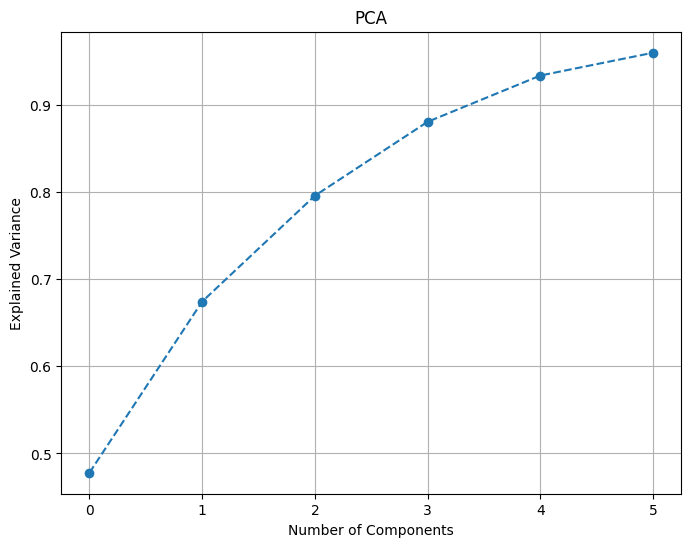

In [28]:
pca3 = PCA(0.95)
pca3.fit(scaled_data3)



# Plot explained variance ratio
explained_variance3 = pca3.explained_variance_ratio_
explained_variance_cumulative3 = np.cumsum(explained_variance3)

plt.figure(figsize=(8, 6))
plt.plot(explained_variance_cumulative3, marker='o', linestyle='--')
plt.title('PCA')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.grid()
plt.show()

In [29]:
pca3.explained_variance_

array([4.77829318, 1.96630842, 1.21587687, 0.84873401, 0.53136618,
       0.2620602 ])

In [30]:
X3.columns

Index(['Rg', 'Tair', 'Tsoil', 'rH', 'VPD', 'Ustar', 'SWC', 'GPP', 'NEE', 'ET'], dtype='object')

In [31]:
loadings = pd.DataFrame(
    data=pca3.components_.T * np.sqrt(pca3.explained_variance_),
    columns=[f'PC{i}' for i in range(1, pca3.components_.shape[0] + 1)],
    index=X3.columns
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
Rg,0.833402,0.307927,-0.144286,-0.050087,-0.034128,0.400082
Tair,0.722445,-0.582646,0.103255,0.106948,-0.248958,-0.043072
Tsoil,0.539678,-0.689941,0.371230,0.186411,-0.110744,-0.059365
rH,-0.478539,-0.106698,0.817316,0.076687,0.063597,0.230926
VPD,0.808632,-0.280544,-0.352960,-0.075723,-0.184582,0.050607
Ustar,0.370365,0.335125,-0.103802,0.843731,0.156339,-0.025181
SWC,-0.233968,0.748316,0.229186,0.063766,-0.565584,-0.077297
GPP,0.864231,0.237192,0.343637,-0.143402,0.147533,-0.127574
NEE,-0.796540,-0.418541,-0.217217,0.224947,-0.221577,0.133351
ET,0.902435,0.249366,0.159461,-0.036180,-0.051493,0.007783


In [32]:
#Project the data onto selected principal components
X3_reduced = pca3.transform(scaled_data3)[:, :n_components3]

In [33]:
X3_reduced.shape

(29603, 6)

In [ ]:
from sklearn.svm import SVR

In [ ]:
# Split the data into training and validation sets (80% train, 20% validation)
X3_train, X3_valid, y3_train, y3_valid = train_test_split(X3_reduced, y3, test_size=0.2, random_state=42)


# Initialize regression models
models = {
    'Linear Regression': LinearRegression(),
    'SVM Regressor': SVR(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost Regressor': XGBRegressor(n_estimators=50, random_state=42)
}

# Initialize dictionaries to store evaluation metrics
rmse_scores = {}
mae_scores = {}
mape_scores = {}
r2_scores = {}

# Iterate through each model
for model_name, model in models.items():
    # Fit the model on the training data
    model.fit(X3_train, y3_train)

    # Predict on the validation data
    y3_pred = model.predict(X3_valid)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y3_valid, y3_pred))
    mae = mean_absolute_error(y3_valid, y3_pred)
    r2 = r2_score(y3_valid, y3_pred)

    # Store metrics in dictionaries
    rmse_scores[model_name] = rmse
    mae_scores[model_name] = mae
    r2_scores[model_name] = r2

# Display the evaluation metrics for each model
print("Regression Metrics:")
for model_name in models.keys():
    print(f"Model: {model_name}")
    print(f"  RMSE: {rmse_scores[model_name]:.2f}")
    print(f"  MAE: {mae_scores[model_name]:.2f}")
    print(f"  R2: {r2_scores[model_name]:.2f}")
    print()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for the models you want to tune
param_grids = {
    'SVM Regressor': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf'],
        'gamma': [0.01, 0.1, 1]
    },
    'Decision Tree Regressor': {
        'max_depth': [3,4,5,6],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest Regressor': {
        'n_estimators': [200,500,1000],
        'max_depth': [3,4,5,6],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost Regressor': {
        'n_estimators': [200, 500, 1000],
        'max_depth': [2,3,4,5,6],
        'learning_rate': [0.01, 0.1, 0.2],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
}

# Initialize dictionaries to store best models and their evaluation metrics
best_models = {}
best_rmse_scores = {}
best_mae_scores = {}
best_r2_scores = {}

# Iterate through each model
for model_name, model in models.items():
    # Check if the model supports hyperparameter tuning
    if model_name in param_grids:
        # Create a GridSearchCV instance for hyperparameter tuning
        grid_search = GridSearchCV(model, param_grids[model_name], scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

        # Fit the GridSearchCV on the training data
        grid_search.fit(X3_train, y3_train)

        # Get the best model with the tuned hyperparameters
        best_model = grid_search.best_estimator_

        # Predict on the validation data with the best model
        y3_pred = best_model.predict(X3_valid)

        # Calculate evaluation metrics
        rmse = np.sqrt(mean_squared_error(y3_valid, y3_pred))
        mae = mean_absolute_error(y3_valid, y3_pred)
        r2 = r2_score(y3_valid, y3_pred)

        # Store the best model and its RMSE score
        best_models[model_name] = best_model
        best_rmse_scores[model_name] = rmse
        best_mae_scores[model_name] = mae
        best_r2_scores[model_name] = r2

# Display the best models and their evaluation metrics
print("Best Models after Hyperparameter Tuning:")
for model_name in best_models.keys():
    print(f"Model: {model_name}")
    print(f"Best Hyperparameters: {best_models[model_name].get_params()}")
    print(f"  RMSE: {best_rmse_scores[model_name]:.2f}")
    print(f"  MAE: {best_mae_scores[model_name]:.2f}")
    print(f"  R2: {best_r2_scores[model_name]:.2f}")
    print()
    print()

**Modelling For GPP**

In [ ]:
y = p20_final_df_model_GPP['ER']
X = p20_final_df_model_GPP.drop(['ER'], axis=1)

In [ ]:
X

,Rg,Tair,Tsoil,rH,VPD,Ustar,SWC,GPP
Date,,,,,,,,
2019-04-01 00:30:00,0.00,2.57,9.73,73.91,0.09,0.05,0.306482,0.55305
2019-04-01 01:00:00,0.00,2.56,9.39,73.33,0.09,0.03,0.306471,0.55226
2019-04-01 01:30:00,0.00,1.88,9.12,76.41,0.09,0.02,0.306262,0.49811
2019-04-01 02:00:00,0.00,1.78,8.83,74.55,0.09,0.03,0.306530,0.49012
2019-04-01 02:30:00,0.00,1.84,8.57,68.79,0.09,0.03,0.305710,0.49492
...,...,...,...,...,...,...,...,...
2022-12-31 18:00:00,19.41,11.24,6.75,64.57,0.89,0.13,0.283907,0.00000
2022-12-31 19:30:00,0.00,7.50,6.58,75.85,0.00,0.07,0.284217,0.00000
2022-12-31 20:30:00,0.00,7.97,6.41,71.28,1.41,0.10,0.284302,0.00000


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

In [ ]:
pca = PCA()
pca.fit(scaled_data)

# Calculate cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

In [ ]:
# Select principal components to explain 95% variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1

n_components

6

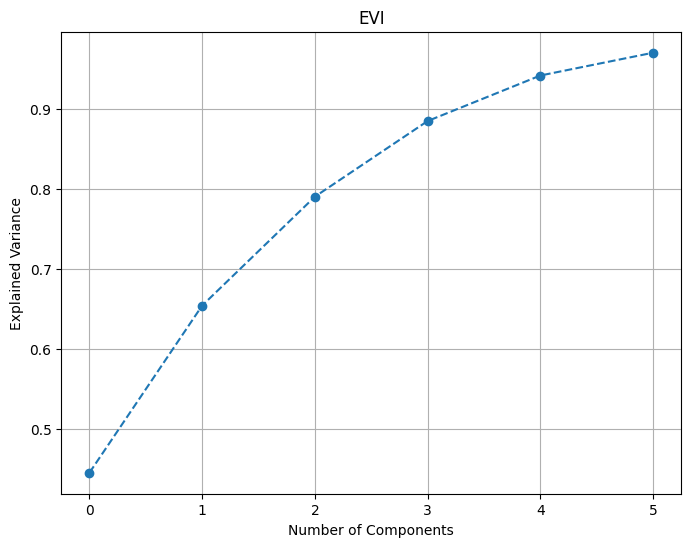

In [ ]:
pca = PCA(0.95)
pca.fit(scaled_data)



# Plot explained variance ratio
explained_variance = pca.explained_variance_ratio_
explained_variance_cumulative = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(explained_variance_cumulative, marker='o', linestyle='--')
plt.title('EVI')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.grid()
plt.show()

In [ ]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_),
    columns=[f'PC{i}' for i in range(1, pca.components_.shape[0] + 1)],
    index=X.columns
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
Rg,0.735275,0.519113,0.069137,-0.208225,0.161179,-0.293085
Tair,0.853699,-0.376773,0.120070,0.013521,-0.259381,-0.002790
Tsoil,0.677713,-0.601293,0.319434,0.101641,-0.134812,0.052865
rH,-0.506735,-0.452645,0.669360,-0.046461,0.130224,-0.229732
VPD,0.885034,0.033377,-0.277719,-0.083014,-0.166898,-0.125497
Ustar,0.316522,0.516483,0.297017,0.736511,0.019553,-0.001247
SWC,-0.431496,0.599503,0.417653,-0.243186,-0.468462,0.025300
GPP,0.709897,0.258853,0.424512,-0.303498,0.281248,0.264857


In [ ]:
#Project the data onto selected principal components
X_reduced = pca.transform(scaled_data)[:, :n_components]

In [ ]:
from sklearn.svm import SVR

In [ ]:
# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_valid, y_train, y_valid = train_test_split(X_reduced, y, test_size=0.2, random_state=42)


# Initialize regression models
models = {
    'Linear Regression': LinearRegression(),
    'SVM Regressor': SVR(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost Regressor': XGBRegressor(n_estimators=50, random_state=42)
}

# Initialize dictionaries to store evaluation metrics
rmse_scores = {}
mae_scores = {}
mape_scores = {}
r2_scores = {}

# Iterate through each model
for model_name, model in models.items():
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the validation data
    y_pred = model.predict(X_valid)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mae = mean_absolute_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)

    # Store metrics in dictionaries
    rmse_scores[model_name] = rmse
    mae_scores[model_name] = mae
    r2_scores[model_name] = r2

# Display the evaluation metrics for each model
print("Regression Metrics:")
for model_name in models.keys():
    print(f"Model: {model_name}")
    print(f"  RMSE: {rmse_scores[model_name]:.2f}")
    print(f"  MAE: {mae_scores[model_name]:.2f}")
    print(f"  R2: {r2_scores[model_name]:.2f}")
    print()

Regression Metrics:
Model: Linear Regression
  RMSE: 2.04
  MAE: 1.38
  R2: 0.49

Model: SVM Regressor
  RMSE: 1.76
  MAE: 0.98
  R2: 0.62

Model: Decision Tree Regressor
  RMSE: 2.32
  MAE: 1.13
  R2: 0.34

Model: Random Forest Regressor
  RMSE: 1.64
  MAE: 0.85
  R2: 0.67

Model: XGBoost Regressor
  RMSE: 1.76
  MAE: 1.01
  R2: 0.62



In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for the models you want to tune
param_grids = {
    'SVM Regressor': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf'],
        'gamma': [0.01, 0.1, 1]
    },
    'Decision Tree Regressor': {
        'max_depth': [3,4,5,6],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest Regressor': {
        'n_estimators': [200,500,1000],
        'max_depth': [3,4,5,6],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost Regressor': {
        'n_estimators': [200, 500, 1000],
        'max_depth': [2,3,4,5,6],
        'learning_rate': [0.01, 0.1, 0.2],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
}

# Initialize dictionaries to store best models and their evaluation metrics
best_models = {}
best_rmse_scores = {}
best_mae_scores = {}
best_r2_scores = {}

# Iterate through each model
for model_name, model in models.items():
    # Check if the model supports hyperparameter tuning
    if model_name in param_grids:
        # Create a GridSearchCV instance for hyperparameter tuning
        grid_search = GridSearchCV(model, param_grids[model_name], scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

        # Fit the GridSearchCV on the training data
        grid_search.fit(X_train, y_train)

        # Get the best model with the tuned hyperparameters
        best_model = grid_search.best_estimator_

        # Predict on the validation data with the best model
        y_pred = best_model.predict(X_valid)

        # Calculate evaluation metrics
        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
        mae = mean_absolute_error(y_valid, y_pred)
        r2 = r2_score(y_valid, y_pred)

        # Store the best model and its RMSE score
        best_models[model_name] = best_model
        best_rmse_scores[model_name] = rmse
        best_mae_scores[model_name] = mae
        best_r2_scores[model_name] = r2

# Display the best models and their evaluation metrics
print("Best Models after Hyperparameter Tuning:")
for model_name in best_models.keys():
    print(f"Model: {model_name}")
    print(f"Best Hyperparameters: {best_models[model_name].get_params()}")
    print(f"  RMSE: {best_rmse_scores[model_name]:.2f}")
    print(f"  MAE: {best_mae_scores[model_name]:.2f}")
    print(f"  R2: {best_r2_scores[model_name]:.2f}")
    print()
    print()

Best Models after Hyperparameter Tuning:
Model: SVM Regressor
Best Hyperparameters: {'C': 10, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 1, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
  RMSE: 1.55
  MAE: 0.72
  R2: 0.71


Model: Decision Tree Regressor
Best Hyperparameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
  RMSE: 2.04
  MAE: 1.27
  R2: 0.49


Model: Random Forest Regressor
Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_sc

 **Modelling For NEE**

In [ ]:
y1 = p20_final_df_model_NEE['ER']
X1 = p20_final_df_model_NEE.drop(['ER'], axis=1)

In [ ]:
X1

,Rg,Tair,Tsoil,rH,VPD,Ustar,SWC,NEE
Date,,,,,,,,
2019-04-01 00:30:00,0.00,2.57,9.73,73.91,0.09,0.05,0.306482,0.61
2019-04-01 01:00:00,0.00,2.56,9.39,73.33,0.09,0.03,0.306471,0.29
2019-04-01 01:30:00,0.00,1.88,9.12,76.41,0.09,0.02,0.306262,1.35
2019-04-01 02:00:00,0.00,1.78,8.83,74.55,0.09,0.03,0.306530,0.63
2019-04-01 02:30:00,0.00,1.84,8.57,68.79,0.09,0.03,0.305710,0.76
...,...,...,...,...,...,...,...,...
2022-12-31 18:00:00,19.41,11.24,6.75,64.57,0.89,0.13,0.283907,3.78
2022-12-31 19:30:00,0.00,7.50,6.58,75.85,0.00,0.07,0.284217,1.59
2022-12-31 20:30:00,0.00,7.97,6.41,71.28,1.41,0.10,0.284302,1.69


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler1 = StandardScaler()
scaled_data1 = scaler1.fit_transform(X1)

In [ ]:
pca1 = PCA()
pca1.fit(scaled_data1)

# Calculate cumulative explained variance
explained_variance_ratio1 = pca1.explained_variance_ratio_
cumulative_variance1 = explained_variance_ratio1.cumsum()

In [ ]:
# Select principal components to explain 95% variance
n_components1 = np.argmax(cumulative_variance1 >= 0.95) + 1

n_components1

6

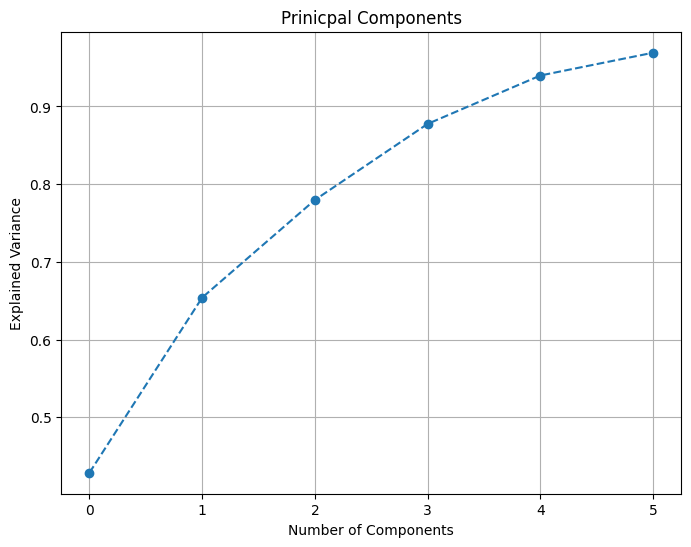

In [ ]:
pca1 = PCA(0.95)
pca1.fit(scaled_data1)



# Plot explained variance ratio
explained_variance1 = pca1.explained_variance_ratio_
explained_variance_cumulative1 = np.cumsum(explained_variance1)

plt.figure(figsize=(8, 6))
plt.plot(explained_variance_cumulative1, marker='o', linestyle='--')
plt.title('Prinicpal Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.grid()
plt.show()

In [ ]:
loadings = pd.DataFrame(
    data=pca1.components_.T * np.sqrt(pca1.explained_variance_),
    columns=[f'PC{i}' for i in range(1, pca1.components_.shape[0] + 1)],
    index=X1.columns
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
Rg,0.755733,0.494833,0.074347,-0.177708,0.062144,-0.353500
Tair,0.827251,-0.426412,0.176137,-0.008510,-0.232528,0.039433
Tsoil,0.630509,-0.635384,0.372265,0.032046,-0.089705,0.068304
rH,-0.553922,-0.394630,0.652781,-0.165547,0.152010,-0.177680
VPD,0.898837,-0.019286,-0.233689,-0.045428,-0.174885,-0.052792
Ustar,0.327433,0.457478,0.373654,0.730294,0.088337,0.019816
SWC,-0.425038,0.617376,0.366147,-0.173233,-0.520162,0.053437
NEE,-0.611287,-0.475649,-0.275329,0.396681,-0.316278,-0.256377


In [ ]:
#Project the data onto selected principal components
X1_reduced = pca1.transform(scaled_data1)[:, :n_components1]

In [ ]:
# Split the data into training and validation sets (80% train, 20% validation)
X1_train, X1_valid, y1_train, y1_valid = train_test_split(X1_reduced, y1, test_size=0.2, random_state=42)


# Initialize regression models
models = {
    'Linear Regression': LinearRegression(),
    'SVM Regressor': SVR(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost Regressor': XGBRegressor(n_estimators=50, random_state=42)
}

# Initialize dictionaries to store evaluation metrics
rmse_scores = {}
mae_scores = {}
mape_scores = {}
r2_scores = {}

# Iterate through each model
for model_name, model in models.items():
    # Fit the model on the training data
    model.fit(X1_train, y1_train)

    # Predict on the validation data
    y1_pred = model.predict(X1_valid)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y1_valid, y1_pred))
    mae = mean_absolute_error(y1_valid, y1_pred)
    r2 = r2_score(y1_valid, y1_pred)

    # Store metrics in dictionaries
    rmse_scores[model_name] = rmse
    mae_scores[model_name] = mae
    r2_scores[model_name] = r2

# Display the evaluation metrics for each model
print("Regression Metrics:")
for model_name in models.keys():
    print(f"Model: {model_name}")
    print(f"  RMSE: {rmse_scores[model_name]:.2f}")
    print(f"  MAE: {mae_scores[model_name]:.2f}")
    print(f"  R2: {r2_scores[model_name]:.2f}")
    print()

Regression Metrics:
Model: Linear Regression
  RMSE: 1.93
  MAE: 1.37
  R2: 0.54

Model: SVM Regressor
  RMSE: 1.09
  MAE: 0.67
  R2: 0.86

Model: Decision Tree Regressor
  RMSE: 1.52
  MAE: 0.81
  R2: 0.72

Model: Random Forest Regressor
  RMSE: 1.00
  MAE: 0.61
  R2: 0.88

Model: XGBoost Regressor
  RMSE: 1.08
  MAE: 0.74
  R2: 0.86



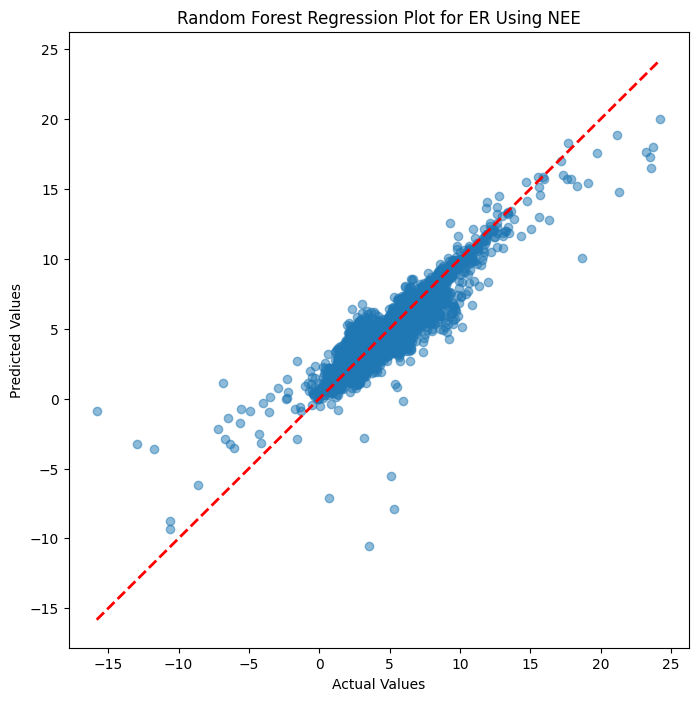

In [ ]:
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X1_train, y1_train)

# Make predictions on the test set
y1_pred = rf_model.predict(X1_valid)

# Create a regression plot
plt.figure(figsize=(8, 8))
plt.scatter(y1_valid, y1_pred, alpha=0.5)
plt.title('Random Forest Regression Plot for ER Using NEE')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y1_valid), max(y1_valid)], [min(y1_valid), max(y1_valid)], linestyle='--', color='red', linewidth=2)  # Diagonal line for reference
plt.show()

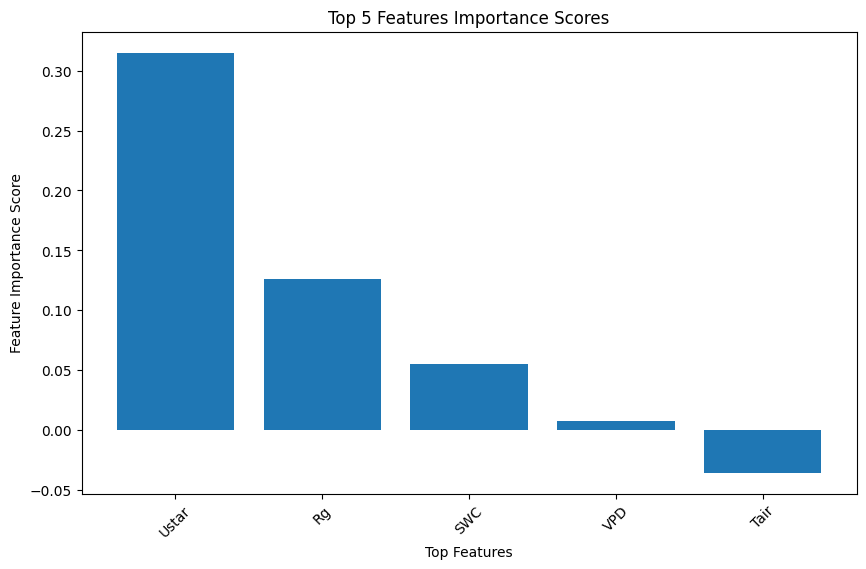

In [ ]:
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X1_train, y1_train)

# Step 2: Extract Feature Importance
feature_importance = rf_model.feature_importances_

# Step 3: Map Feature Importance to Original Features (if you know how PCA components are constructed)
# Example: mapping importance scores back to the original features
original_feature_importance = pca1.components_.T @ feature_importance

# Step 4: Select Top Features
top_features_indices = original_feature_importance.argsort()[-5:][::-1]
top_features = X1.columns[top_features_indices]

import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already identified top_features
# Example: top_features = ['feature1', 'feature2', 'feature3', 'feature4', 'feature5']

# Plotting the feature importance scores for the top features
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_features)), original_feature_importance[top_features_indices], align='center')
plt.xticks(range(len(top_features)), top_features, rotation=45)
plt.xlabel('Top Features')
plt.ylabel('Feature Importance Score')
plt.title('Top 5 Features Importance Scores')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for the models you want to tune
param_grids = {
    'SVM Regressor': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf'],
        'gamma': [0.01, 0.1, 1]
    },
    'Decision Tree Regressor': {
        'max_depth': [3,4,5,6],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest Regressor': {
        'n_estimators': [200,300,500,1000],
        'max_depth': [3,4,5,6],
        'min_samples_split': [2,3,4,5]
    },
    'XGBoost Regressor': {
        'n_estimators': [200, 500, 1000],
        'max_depth': [2,3,4,5,6],
        'learning_rate': [0.01, 0.1, 0.2],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
}

# Initialize dictionaries to store best models and their evaluation metrics
best_models = {}
best_rmse_scores = {}
best_mae_scores = {}
best_r2_scores = {}

# Iterate through each model
for model_name, model in models.items():
    # Check if the model supports hyperparameter tuning
    if model_name in param_grids:
        # Create a GridSearchCV instance for hyperparameter tuning
        grid_search = GridSearchCV(model, param_grids[model_name], scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

        # Fit the GridSearchCV on the training data
        grid_search.fit(X1_train, y1_train)

        # Get the best model with the tuned hyperparameters
        best_model = grid_search.best_estimator_

        # Predict on the validation data with the best model
        y1_pred = best_model.predict(X1_valid)

        # Calculate evaluation metrics
        rmse = np.sqrt(mean_squared_error(y1_valid, y1_pred))
        mae = mean_absolute_error(y1_valid, y1_pred)
        r2 = r2_score(y1_valid, y1_pred)

        # Store the best model and its RMSE score
        best_models[model_name] = best_model
        best_rmse_scores[model_name] = rmse
        best_mae_scores[model_name] = mae
        best_r2_scores[model_name] = r2

# Display the best models and their evaluation metrics
print("Best Models after Hyperparameter Tuning:")
for model_name in best_models.keys():
    print(f"Model: {model_name}")
    print(f"Best Hyperparameters: {best_models[model_name].get_params()}")
    print(f"  RMSE: {best_rmse_scores[model_name]:.2f}")
    print(f"  MAE: {best_mae_scores[model_name]:.2f}")
    print(f"  R2: {best_r2_scores[model_name]:.2f}")
    print()
    print()

Best Models after Hyperparameter Tuning:
Model: SVM Regressor
Best Hyperparameters: {'C': 10, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 1, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
  RMSE: 0.85
  MAE: 0.43
  R2: 0.91


Model: Decision Tree Regressor
Best Hyperparameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
  RMSE: 1.70
  MAE: 1.16
  R2: 0.65


Model: Random Forest Regressor
Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_s

**Modelling For ET**



In [34]:
y2 = p20_final_df_model_ET['ER']
X2 = p20_final_df_model_ET.drop(['ER'], axis=1)

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler2 = StandardScaler()
scaled_data2 = scaler2.fit_transform(X2)

In [36]:
pca2 = PCA()
pca2.fit(scaled_data2)

# Calculate cumulative explained variance
explained_variance_ratio2 = pca2.explained_variance_ratio_
cumulative_variance2 = explained_variance_ratio2.cumsum()

In [37]:
# Select principal components to explain 95% variance
n_components2 = np.argmax(cumulative_variance2 >= 0.95) + 1
n_components2

6

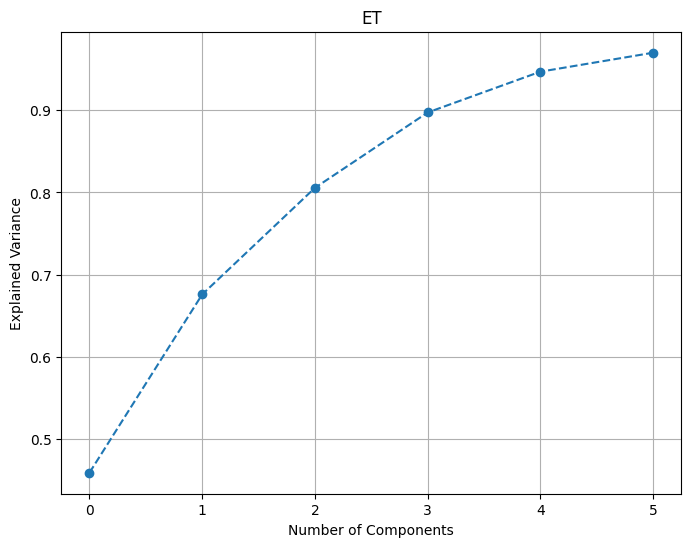

In [38]:
pca2 = PCA(0.95)
pca2.fit(scaled_data2)


# Plot explained variance ratio
explained_variance2 = pca2.explained_variance_ratio_
explained_variance_cumulative2 = np.cumsum(explained_variance2)

plt.figure(figsize=(8, 6))
plt.plot(explained_variance_cumulative2, marker='o', linestyle='--')
plt.title('ET')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.grid()
plt.show()

In [39]:
loadings = pd.DataFrame(
    data=pca2.components_.T * np.sqrt(pca2.explained_variance_),
    columns=[f'PC{i}' for i in range(1, pca2.components_.shape[0] + 1)],
    index=X2.columns
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
Rg,0.757491,0.479370,0.037350,-0.193248,0.283095,-0.207103
Tair,0.833529,-0.419273,0.157395,-0.040798,-0.228993,-0.075257
Tsoil,0.645286,-0.627322,0.361727,0.033723,-0.104353,0.084265
rH,-0.538998,-0.408418,0.658581,-0.111238,0.229335,-0.156530
VPD,0.896022,-0.014615,-0.253446,-0.089233,-0.128806,-0.158636
Ustar,0.342879,0.494278,0.367778,0.706724,-0.032969,-0.030371
SWC,-0.393379,0.641099,0.408722,-0.335446,-0.389627,-0.038535
ET,0.786894,0.339100,0.284466,-0.248638,0.178964,0.277367


In [40]:
#Project the data onto selected principal components
X2_reduced = pca2.transform(scaled_data2)[:, :n_components2]

In [43]:
from sklearn.svm import SVR

In [44]:
# Split the data into training and validation sets (80% train, 20% validation)
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2_reduced, y2, test_size=0.2, random_state=42)


# Initialize regression models
models = {
    'Linear Regression': LinearRegression(),
    'SVM Regressor': SVR(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost Regressor': XGBRegressor(n_estimators=50, random_state=42)
}

# Initialize dictionaries to store evaluation metrics
rmse_scores = {}
mae_scores = {}
mape_scores = {}
r2_scores = {}

# Iterate through each model
for model_name, model in models.items():
    # Fit the model on the training data
    model.fit(X2_train, y2_train)

    # Predict on the validation data
    y2_pred = model.predict(X2_valid)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(y2_valid, y2_pred))
    mae = mean_absolute_error(y2_valid, y2_pred)
    r2 = r2_score(y2_valid, y2_pred)

    # Store metrics in dictionaries
    rmse_scores[model_name] = rmse
    mae_scores[model_name] = mae
    r2_scores[model_name] = r2

# Display the evaluation metrics for each model
print("Regression Metrics:")
for model_name in models.keys():
    print(f"Model: {model_name}")
    print(f"  RMSE: {rmse_scores[model_name]:.2f}")
    print(f"  MAE: {mae_scores[model_name]:.2f}")
    print(f"  R2: {r2_scores[model_name]:.2f}")
    print()

Regression Metrics:
Model: Linear Regression
  RMSE: 2.04
  MAE: 1.38
  R2: 0.49

Model: SVM Regressor
  RMSE: 1.78
  MAE: 1.02
  R2: 0.61

Model: Decision Tree Regressor
  RMSE: 2.34
  MAE: 1.18
  R2: 0.33

Model: Random Forest Regressor
  RMSE: 1.68
  MAE: 0.89
  R2: 0.65

Model: XGBoost Regressor
  RMSE: 1.78
  MAE: 1.04
  R2: 0.61



In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for the models you want to tune
param_grids = {
    'SVM Regressor': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf'],
        'gamma': [0.01, 0.1, 1]
    },
    'Decision Tree Regressor': {
        'max_depth': [3,4,5,6],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest Regressor': {
        'n_estimators': [200,300,500,1000],
        'max_depth': [4,5,6,7],
        'min_samples_split': [2,3,4,5]
    },
    'XGBoost Regressor': {
        'n_estimators': [200, 500, 1000],
        'max_depth': [2,3,4,5,6],
        'learning_rate': [0.01, 0.1, 0.2],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
}

# Initialize dictionaries to store best models and their evaluation metrics
best_models = {}
best_rmse_scores = {}
best_mae_scores = {}
best_r2_scores = {}

# Iterate through each model
for model_name, model in models.items():
    # Check if the model supports hyperparameter tuning
    if model_name in param_grids:
        # Create a GridSearchCV instance for hyperparameter tuning
        grid_search = GridSearchCV(model, param_grids[model_name], scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

        # Fit the GridSearchCV on the training data
        grid_search.fit(X2_train, y2_train)

        # Get the best model with the tuned hyperparameters
        best_model = grid_search.best_estimator_

        # Predict on the validation data with the best model
        y2_pred = best_model.predict(X2_valid)

        # Calculate evaluation metrics
        rmse = np.sqrt(mean_squared_error(y2_valid, y2_pred))
        mae = mean_absolute_error(y2_valid, y2_pred)
        r2 = r2_score(y2_valid, y2_pred)

        # Store the best model and its RMSE score
        best_models[model_name] = best_model
        best_rmse_scores[model_name] = rmse
        best_mae_scores[model_name] = mae
        best_r2_scores[model_name] = r2

# Display the best models and their evaluation metrics
print("Best Models after Hyperparameter Tuning:")
for model_name in best_models.keys():
    print(f"Model: {model_name}")
    print(f"Best Hyperparameters: {best_models[model_name].get_params()}")
    print(f"  RMSE: {best_rmse_scores[model_name]:.2f}")
    print(f"  MAE: {best_mae_scores[model_name]:.2f}")
    print(f"  R2: {best_r2_scores[model_name]:.2f}")
    print()
    print()

NameError: ignored

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for the models you want to tune
param_grids = {
    'SVM Regressor': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf'],
        'gamma': [0.01, 0.1, 1]
    },
    'Decision Tree Regressor': {
        'max_depth': [3,4,5,6],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest Regressor': {
        'n_estimators': [200,500,1000,2000],
        'max_depth': [3,4,5,6],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost Regressor': {
        'n_estimators': [200, 500, 1000],
        'max_depth': [2,3,4,5,6],
        'learning_rate': [0.01, 0.1, 0.2],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
}

# Initialize dictionaries to store best models and their evaluation metrics
best_models = {}
best_rmse_scores = {}
best_mae_scores = {}
best_r2_scores = {}

# Iterate through each model
for model_name, model in models.items():
    # Check if the model supports hyperparameter tuning
    if model_name in param_grids:
        # Create a GridSearchCV instance for hyperparameter tuning
        grid_search = GridSearchCV(model, param_grids[model_name], scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

        # Fit the GridSearchCV on the training data
        grid_search.fit(X2_train, y2_train)

        # Get the best model with the tuned hyperparameters
        best_model = grid_search.best_estimator_

        # Predict on the validation data with the best model
        y2_pred = best_model.predict(X2_valid)

        # Calculate evaluation metrics
        rmse = np.sqrt(mean_squared_error(y2_valid, y2_pred))
        mae = mean_absolute_error(y2_valid, y2_pred)
        r2 = r2_score(y2_valid, y2_pred)

        # Store the best model and its RMSE score
        best_models[model_name] = best_model
        best_rmse_scores[model_name] = rmse
        best_mae_scores[model_name] = mae
        best_r2_scores[model_name] = r2

# Display the best models and their evaluation metrics
print("Best Models after Hyperparameter Tuning:")
for model_name in best_models.keys():
    print(f"Model: {model_name}")
    print(f"Best Hyperparameters: {best_models[model_name].get_params()}")
    print(f"  RMSE: {best_rmse_scores[model_name]:.2f}")
    print(f"  MAE: {best_mae_scores[model_name]:.2f}")
    print(f"  R2: {best_r2_scores[model_name]:.2f}")
    print()
    print()

NameError: ignored